In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt

import config

import transform_post_prediction
import read_experiment_results 
from read_experiment_results import compile_simulation_results
from transform_post_prediction import transform_and_compute_metrics


This notebook takes the results of the simulations that generate predictions, and investigates two different calibration procedures:
1. an additive calibration that assigns an additive offset to the predicted values, where the offset differs for regions classified (or predicted) as urban or rural
2. a threshold recalibration that assigns targeting thresholds differently to regions that are classified (or predicted) as urban or rural


In [2]:
def clean_plot(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.tight_layout

# 1. read in simulated predictions

In [3]:
# complie country names
countries = []
countries += [('mexico', 'asset_index')]
countries += [('us', 'FINCP')]
countries += [('india', 'secc_cons_pc_combined')]
dhs_countries = ['colombia', 'honduras', 'indonesia','kenya','nigeria','peru', 'philippines']
for country in dhs_countries:
    countries += [(f'dhs/{country}', 'wealth')]


country_names = [x[0] for x in countries]


country_names = ['Mexico', 
                 'United States',
                 'India',
                 'Colombia', 
                 'Honduras',
                 'Indonesia', 
                 'Kenya', 
                 'Nigeria', 
                 'Peru',
                 'Philippines', 
]


# whether to use spatial holdout
n = 100
spatial = False
clip_preds = False
flip_yhat_rural = True

simulation_results = compile_simulation_results(countries,
                                                spatial = spatial,
                                                n = n,
                                                clip_preds=clip_preds,
                                                flip_yhat_rural=flip_yhat_rural)

test_dfs_by_country, train_dfs_by_country = simulation_results

mexico
us
india
dhs/colombia
dhs/honduras
dhs/indonesia
dhs/kenya
dhs/nigeria
dhs/peru
dhs/philippines


In [4]:
def apply_conditions_to_all_countries(test_dfs_by_country,
                                      train_dfs_by_country, 
                                      countries,
                                      pred_transform_conditions,
                                      thresh_transform_conditions,
                                      precentile_targeting=20,
                                      n_trials = 100):
    metrics_by_country = []
    output_by_country = []
    for test_dfs, train_dfs, country in zip(test_dfs_by_country,train_dfs_by_country, countries):
        metrics, output = transform_and_compute_metrics(test_dfs, 
                                                        train_dfs,
                                                        pred_transform_conditions,
                                                        thresh_transform_conditions,
                                                        percentile_targeting=precentile_targeting,
                                                        n_trials=n_trials)
        metrics_by_country.append(metrics)
        output_by_country.append(output)
        
    return metrics_by_country, output_by_country


In [5]:
# basic predictions single threshold
pred_transform_kwargs0 = {'transform_strategy': 'none'}
thresh_transform_kwargs0 = {'thresh_strategy': 'single_thresh'}
res0 = apply_conditions_to_all_countries(test_dfs_by_country,
                                         train_dfs_by_country, 
                                         countries,
                                         pred_transform_kwargs0,
                                         thresh_transform_kwargs0,
                                         n_trials=n)
metrics_cond0, output_cond0 = res0
descriptor_cond0 = 'untransformed predictions'

In [6]:
pred_transform_kwargs1a = {'g_column': 'rural',
                           'g_column_compute_transform': 'rural',
                           'transform_strategy': 'additive_constant',
                           'transform_with':'train',
                           'verbose': False}

pred_transform_kwargs1b = {'g_column': 'yhat_rural_bin',
                           'g_column_compute_transform': 'rural',
                           'transform_strategy': 'additive_constant',
                           'transform_with': 'train',
                           'verbose': False}

thresh_transform_kwargs1 = thresh_transform_kwargs0.copy()

metrics_cond1, output_cond1 = [], []

for pred_transform in [pred_transform_kwargs1a, pred_transform_kwargs1b]:
    res = apply_conditions_to_all_countries(test_dfs_by_country,
                                            train_dfs_by_country, 
                                            countries,
                                            pred_transform,
                                            thresh_transform_kwargs1,
                                            n_trials=n)
    metrics_cond1.append(res[0])  
    output_cond1.append(res[1])

metrics_cond1a, metrics_cond1b = metrics_cond1
descriptor_cond1a = 'additive transform with true rural'

In [7]:
pred_transform_kwargs2 = pred_transform_kwargs0.copy()


thresh_transform_kwargs2a = {'thresh_strategy': 'match_rural_rates_in_train',
                            'rural_measure': 'rural',
                            'rural_measure_train': 'rural'}

thresh_transform_kwargs2b = {'thresh_strategy': 'match_rural_rates_in_train',
                             'rural_measure': 'yhat_rural_bin',
                             'rural_measure_train': 'rural'}

metrics_cond2, output_cond2 = [], []

for thresh_transform in [thresh_transform_kwargs2a, thresh_transform_kwargs2b]:
    res = apply_conditions_to_all_countries(test_dfs_by_country,
                                            train_dfs_by_country, 
                                            countries,
                                            pred_transform_kwargs2,
                                            thresh_transform,
                                            n_trials=n)

    metrics_cond2.append(res[0])
    output_cond2.append(res[1])

metrics_cond2a, metrics_cond2b = metrics_cond2


In [8]:
colors = sns.color_palette("bright")

country_names_plot = np.sort(['United States',
                      'Mexico', 
                      'India',
                     'Colombia',
                      'Honduras', 
                      'Indonesia', 
                      'Nigeria',
                      'Kenya', 
                      'Philippines',
                      'Peru', 
                     ])

def scatter(metrics_by_country_cond_x, 
            metrics_by_country_cond_y, 
            plot_key,
            whiten=False,
            country_labels = True,
            ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(aspect='equal')
        
    mins, maxs = 1,0
        
    for color_index,country_name_this in enumerate(country_names_plot):
        c = np.where([x == country_name_this for x in country_names])[0][0]
        
        vals_x = np.array(metrics_by_country_cond_x[c][plot_key])# for m in metrics_by_country_cond_x])
        vals_y = np.array(metrics_by_country_cond_y[c][plot_key])# for m in metrics_by_country_cond_y])
    
        if 'recall' in plot_key:
            vals_x = vals_x[~np.isnan(vals_x)]
            vals_y = vals_y[~np.isnan(vals_y)]
            
        n_x = len(vals_x)
        std_to_errbar_x = 2.0 / np.sqrt(n_x)
        n_y = len(vals_y)
        std_to_errbarr_y = 2.0 / np.sqrt(n_y)
    
        msize = 60
        if country_names[c] in ["United States", "Mexico", "India"]: mstyle = 's'
        else: mstyle = 'o'
        if country_labels: label = country_names[c]
        else: label = None
            

        if whiten:
            facecolor = [1 - (1-x)/8 for x in colors[color_index]]
        else:
            facecolor = colors[color_index]
        
        ax.errorbar(vals_x.mean(), 
                    vals_y.mean(), 
                    vals_x.std() * std_to_errbar_x, 
                    vals_y.std() * std_to_errbarr_y, 
                    color = colors[color_index],
                    lw=2,)
        
        ax.scatter(vals_x.mean(),
                   vals_y.mean(),
                   edgecolor = colors[color_index],
                   label=label,
                   s = msize,
                   marker = mstyle,
                   zorder=2,
                   linewidth=2,
                   color=facecolor
                  )
        
        mins = np.min([mins, vals_x.mean(), vals_y.mean()])
        maxs = np.max([maxs, vals_x.mean(), vals_y.mean()])
        
        #xlim, ylim = ax.get_xlim(), ax.get_ylim()
        
        if 'bias' in plot_key:
            ax.axhline(0, color='black')
            ax.plot([mins, maxs], [mins, maxs], color='grey')

## Figure 4

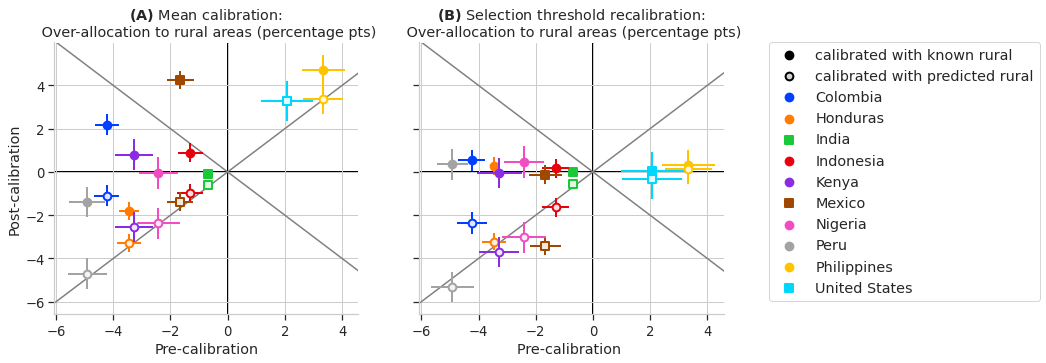

In [9]:
sns.set(font_scale=1.2, style='whitegrid')

country_names = ['Mexico', 
                 'United States',
                 'India',
                 'Colombia', 
                 'Honduras',
                 'Indonesia', 
                 'Kenya', 
                 'Nigeria', 
                 'Peru',
                 'Philippines', 
]


plot_metric = 'rural_alloc_diff'

fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=False, sharey=True)

#if len(plot_metrics) == 1: axes = [axes]

scatter(metrics_cond0,
        metrics_cond1a,
            plot_metric,
            ax=axes[0],  
)
scatter(metrics_cond0,
        metrics_cond1b,
        plot_metric,
        ax=axes[0],  
        whiten=True  
)


scatter(metrics_cond0,
        metrics_cond2a,
        plot_metric,
        ax=axes[1],  
)
scatter(metrics_cond0,
        metrics_cond2b,
        plot_metric,
        ax=axes[1],  
        country_labels = False,
        whiten=True   
)

xlim, ylim = axes[0].get_xlim(), axes[0].get_ylim()

x1, x2 = np.min((xlim[0], ylim[0])), np.max((xlim[1], ylim[1]))

axes[1].scatter([-100], [100],
                color='black',
                s=60,
                       lw=2,
                label=f'calibrated with known rural')
axes[1].scatter([-100], [100],
                s=60,
                       lw=2,
                    color='lightgrey',
                    edgecolor='black',
                    label=f'calibrated with predicted rural')
        
for ax in axes:
    ax.plot([x1,x2],[x1,x2], color='grey',alpha=1, zorder=1)
    ax.plot([x1,x2],[-x1,-x2], color='grey',alpha=1, zorder=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    

axes[0].set_title(r'$\bf{(A)}$ Mean calibration:' '\n Over-allocation to rural areas (percentage pts)')
axes[1].set_title(r'$\bf{(B)}$ Selection threshold recalibration:' '\n Over-allocation to rural areas (percentage pts)')
axes[0].set_xlabel('Pre-calibration', fontsize='medium')
axes[1].set_xlabel('Pre-calibration ', fontsize='medium')
axes[0].set_ylabel('Post-calibration', fontsize='medium')

# make black and white show up first in legend
handles, labels = plt.gca().get_legend_handles_labels()
order = [10,11] + list(np.arange(10))
axes[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
               loc = (1.15,0.05),fontsize='medium')

for ax in axes:
    ax.axhline(0, color='black', linewidth=2, zorder=-1)
    ax.axvline(0, color='black', linewidth=2, zorder=-1)
    clean_plot(ax)

figure_path = '/home/erolf/fairsiml_figs/'
#plt.tight_layout()
plt.savefig(f'{figure_path}/Figure4.png', bbox_inches="tight", dpi=500)
plt.show()

## Plot performance and bias

In [ ]:
plot_metrics = ['spearman_all', 'r2_all', 'bias_rural', 'bias_urban']
titles = ['Spearman r', 'R2 Score', 'bias to rural', 'bias to urban']

fig, axes = plt.subplots(1,len(plot_metrics), 
                         figsize=(5*len(plot_metrics),5), 
                         sharex=False, sharey=False)

#if len(plot_metrics) == 1: axes = [axes]

for p,plot_metric in enumerate(plot_metrics):
    scatter(metrics_cond0,
            metrics_cond1a,
                plot_metric,
                ax=axes[p],  
           #     plotting_kwargs = {}    
    )
    scatter(metrics_cond0,
            metrics_cond1b,
            plot_metric,
            ax=axes[p],  
            country_labels = False,
            whiten=True  
    )

axes[0].plot([.7,.85],[.7,.85], color='grey',alpha=0.5)

axes[1].plot([.4,.75],[.4,.75], color='grey',alpha=0.5)

for t,title in enumerate(titles):
    axes[t].set_title(title)
    axes[t].set_xlabel('performance of original predictions')
    if t == 0:
        axes[t].set_ylabel('performance of calibrated predictions')
# axes[1].set_title('strategy 2: \ncalibration to allocation thresholds')
 
# axes[1].set_xlabel('recall of predictions')
# axes[0].set_ylabel('recall after calibration')

xlim, ylim = axes[-1].get_xlim(), axes[-1].get_ylim()


axes[-1].scatter([-100], [100],
                color='black',
                label=f'calibrated with true rural')
axes[-1].scatter([-100], [100],
                    color='lightgrey',
                    edgecolor='black',
                    label=f'calibrated with predicted rural')
        
axes[-1].set_xlim(xlim)
axes[-1].set_ylim(ylim)
    
    
# make black and white show up first in legend
handles, labels = plt.gca().get_legend_handles_labels()
order = [10,11] + list(np.arange(10))
axes[-1].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
               loc = (1.1,0.1),fontsize=12)



figure_path = '/home/erolf/fairsiml_figs/'
#plt.tight_layout()
plt.savefig(f'{figure_path}/recalibration_to_pred_perf.png', bbox_inches="tight")
plt.show()

In [14]:
for key in ['spearman_all', 'r2_all']:
    mean_cal = np.array([np.mean(x[key]) for x in metrics_cond1a])
    mean_pred = np.array([np.mean(x[key]) for x in metrics_cond0])
    diffs = mean_cal - mean_pred

    print(f'diff in {key} after calibration between {np.min(diffs):.3f} and {np.max(diffs):.3f}')

diff in spearman_all after calibration between 0.000 and 0.018
diff in r2_all after calibration between -0.000 and 0.023


## Plot recall

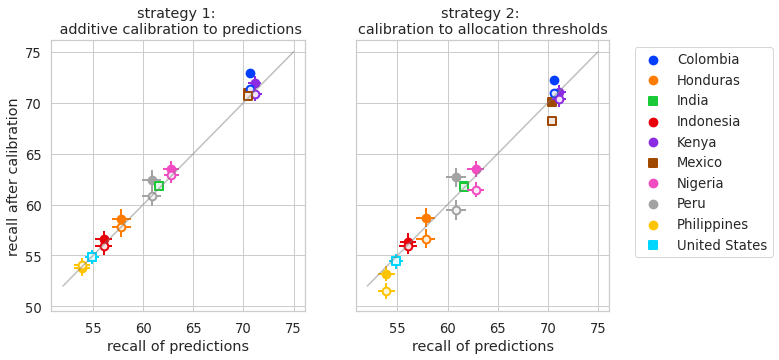

In [17]:
plot_metric = 'recall_all'

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

#if len(plot_metrics) == 1: axes = [axes]

scatter(metrics_cond0,
            metrics_cond1a,
            plot_metric,
            ax=axes[0],  
)
scatter(metrics_cond0,
            metrics_cond1b,
            plot_metric,
            ax=axes[0],  
            whiten=True     
)


scatter(metrics_cond0,
        metrics_cond2a,
        plot_metric,
        ax=axes[1],  
)
scatter(metrics_cond0,
        metrics_cond2b,
        plot_metric,
        ax=axes[1],  
        country_labels = False,
        whiten=True   
)

for ax in axes:
    ax.plot([52,75],[52,75], color='grey',alpha=0.5)

axes[0].set_title('strategy 1: \n additive calibration to predictions')
axes[1].set_title('strategy 2: \ncalibration to allocation thresholds')
axes[0].set_xlabel('recall of predictions')
axes[1].set_xlabel('recall of predictions')
axes[0].set_ylabel('recall after calibration')
axes[1].legend(loc = (1.1,0.2))